# Notes
### 1. variable: eta_t
    default fill value: -32,768
#### (a) time_ytocean_arr\[0] contains missing values <br>
![time_ytocean_arr](images/time_ytocean_arr.png)
#### (b) time_ytocean_arr.data\[0] fills the missing values with default '_FillValue: -32768' <br>
![time_ytocean_arr_data](images/time_ytocean_arr_data.png) <br>
Q: -32768 is too large compare with other values (range between -2 to 0), so what is the resonable value to fill the missing value? mean? median?


In [1]:
import netCDF4 as nc4
import keras
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


In [2]:
file_path =['C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')

In [3]:
file_path

['C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc',
 'C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc',
 'C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc',
 'C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc']

In [3]:
ds = nc4.MFDataset(file_path)
eta_t_arr = ds.variables['eta_t'][:]

In [4]:
ds.variables['eta_t']

<class 'netCDF4._netCDF4._Variable'>
int16 eta_t('Time', 'yt_ocean', 'xt_ocean')
    long_name: surface height on T cells [Boussinesq (volume conserving) model]
    units: meter
    valid_range: [-32767  32767]
    missing_value: -32768
    _FillValue: -32768
    packing: 4
    scale_factor: 0.03051851
    add_offset: 0.0
    cell_methods: time: mean
    time_avg_info: average_T1,average_T2,average_DT
    coordinates: geolon_t geolat_t
unlimited dimensions = ('Time',)
current size = (121, 1500, 3600)

In [5]:
eta_t_arr.shape

(121, 1500, 3600)

In [6]:
# raise an OOM error
time_ytocean_xtocean_arr = eta_t_arr.reshape(121,1500*3600)
time_ytocean_xtocean_arr.shape

(121, 5400000)

In [7]:
time_ytocean_arr = eta_t_arr[:,:,0]
time_ytocean_arr.shape

(121, 1500)

In [8]:
time_ytocean_arr[0]

masked_array(data=[--, --, --, ..., -0.8239997625350952,
                   -0.8239997625350952, -0.7629627585411072],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [9]:
time_ytocean_arr[0].data

array([-3.2768000e+04, -3.2768000e+04, -3.2768000e+04, ...,
       -8.2399976e-01, -8.2399976e-01, -7.6296276e-01], dtype=float32)

In [10]:
import statistics
statistics.median(time_ytocean_arr[0])

0.06103701889514923

In [11]:
for i in range(0,len(time_ytocean_arr)):
    arr = time_ytocean_arr[i].data
    arr[arr == -32768] = statistics.median(time_ytocean_arr[i])

In [18]:
time_ytocean_arr[0].data

array([ 0.06103702,  0.06103702,  0.06103702, ..., -0.82399976,
       -0.82399976, -0.76296276], dtype=float32)

In [19]:
# split into train & test
time_ytocean_train, time_ytocean_test = train_test_split(time_ytocean_arr.data, test_size=0.33)
time_ytocean_train.shape

(81, 1500)

In [20]:
input_size = 1500
hidden_size = 150
output_size = 1500

In [21]:
# fit a single layer autoencoder
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='tanh')(x)
r = Dense(output_size, activation='tanh')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
dense (Dense)                (None, 150)               225150    
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              226500    
Total params: 451,650
Trainable params: 451,650
Non-trainable params: 0
_________________________________________________________________


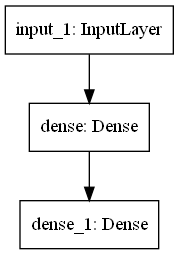

In [12]:
keras.utils.plot_model(autoencoder, "time_ytocean_autoencoder.png")

In [22]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='tanh')(x)
r = Dense(output_size, activation='tanh')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
epochs = 100
batch_size = 1500

history = autoencoder.fit(time_ytocean_train, time_ytocean_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(time_ytocean_test, time_ytocean_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               225150    
_________________________________________________________________
dense_3 (Dense)              (None, 1500)              226500    
Total params: 451,650
Trainable params: 451,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6159 - val_loss: 0.5191
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.5234 - val_loss: 0.4574
Epoch 3/100
1/1 [==============================] - 0s 62ms/step - loss: 0.4619 - val_loss: 0.4057
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 0.4102 - val_loss: 

dict_keys(['loss', 'val_loss'])


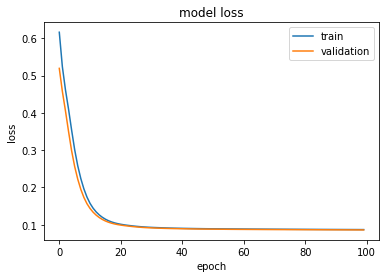

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [24]:
time_ytocean_test_pred = autoencoder.predict(time_ytocean_test)

In [25]:
time_ytocean_test_pred[0]

array([-0.07545418,  0.0187434 , -0.05015349, ..., -0.8571007 ,
       -0.83875453, -0.7819084 ], dtype=float32)

In [27]:
time_ytocean_test[0]

array([-0.06103702, -0.06103702, -0.06103702, ..., -0.79348123,
       -0.79348123, -0.7324442 ], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

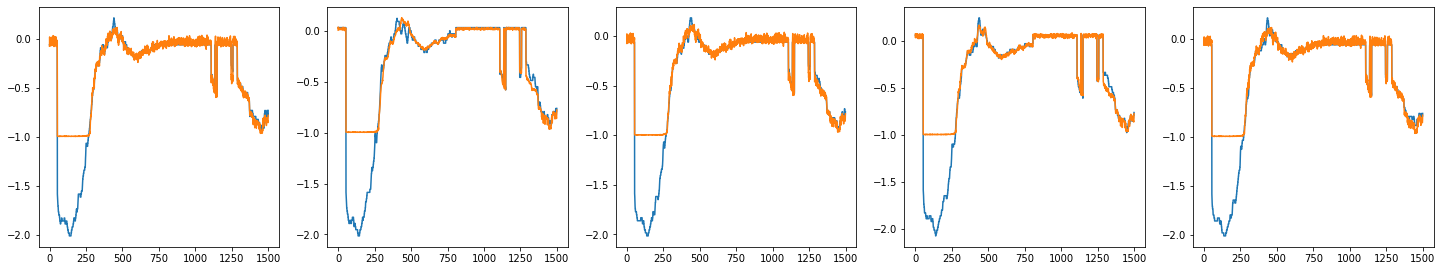

In [32]:
n = 5
plt.figure(figsize=(25, 15))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.plot(time_ytocean_test[i])

    ax = ax = plt.subplot(3, n, i+1)
    plt.plot(time_ytocean_test_pred[i])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

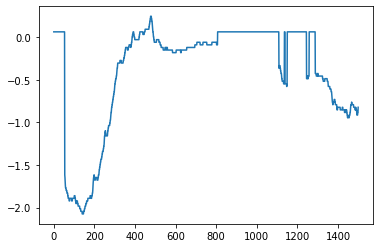

In [33]:
plt.plot(time_ytocean_train[0])
plt.show

# Adding more layers

In [21]:
input_size = 1500
hidden_size = 150
output_size = 1500

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(output_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(output_size, activation='sigmoid')(hidden_2)

autoencoder_m = Model(inputs=x, outputs=r)
autoencoder_m.compile(optimizer='adam', loss='mse')

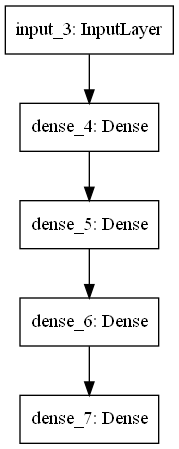

In [30]:
keras.utils.plot_model(autoencoder, "time_ytocean_multilayer_autoencoder.png")

In [22]:
epochs = 100
batch_size = 1500

history_m = autoencoder_m.fit(time_ytocean_train, time_ytocean_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(time_ytocean_test, time_ytocean_test))

Epoch 1/100
1/1 [==============================] - 1s 717ms/step - loss: 1.2025 - val_loss: 1.1810
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 1.1828 - val_loss: 1.1402
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 1.1419 - val_loss: 1.0665
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 1.0680 - val_loss: 0.9636
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.9650 - val_loss: 0.8530
Epoch 6/100
1/1 [==============================] - 0s 60ms/step - loss: 0.8543 - val_loss: 0.7595
Epoch 7/100
1/1 [==============================] - 0s 61ms/step - loss: 0.7608 - val_loss: 0.6927
Epoch 8/100
1/1 [==============================] - 0s 60ms/step - loss: 0.6940 - val_loss: 0.6463
Epoch 9/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6476 - val_loss: 0.6118
Epoch 10/100
1/1 [==============================] - 0s 63ms/step - loss: 0.6131 - val_loss: 0.5851
Epoch 11/100
1/1 [

dict_keys(['loss', 'val_loss'])


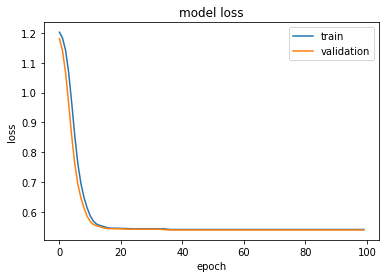

In [23]:
print(history.history.keys())

plt.plot(history_m.history['loss'])
plt.plot(history_m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

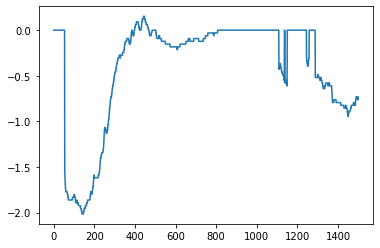

In [24]:
plt.plot(time_ytocean_train[0])